In [1]:
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
!pip install scikit-metrics
!pip install -U scikit-learn
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from torchvision import transforms
import logging
from collections import namedtuple
from glob import glob
from torch.utils.data import Dataset, DataLoader
import os, sys
import skimage
import argparse
import numpy as np
import nibabel as nib
from nibabel.analyze import AnalyzeHeader
from PIL import ImageOps, ImageEnhance
import torch
import torch.nn.functional as nnf
from PIL.Image import BILINEAR
from google.colab import drive
import random
from __future__ import print_function

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-metrics: filename=scikit_metrics-0.1.0-py3-none-any.whl size=4417 sha256=c250042a00154521b438830b8659a0b5f2aaf23e674ba1b6cd27b01e200d25ed
  Stored in directory: /root/.cache/pip/wheels/53/be/d3/0efbe0f00adc8351cb1eee0bd923af7b5375007a50dda2f7f1
Successfully built scikit-metrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [13]:
def resize_image(image, image_shape):
  
    image = skimage.transform.resize(image, image_shape, anti_aliasing=True)
    return image.astype(np.float32)

In [2]:
class Transpose:
    def __call__(self, sample):
        image1, image2 = sample
        image1 = image1.transpose((2,0,1))
        image2 = image2.transpose((2,0,1))
        return (image1, image2)


In [3]:
class ToTensor:
    def __init__(self, training=True):
        self.training = training
    def __call__(self, sample):
        if self.training:
            image1, image2 = sample
            return torch.stack((torch.Tensor(image1), torch.Tensor(image2)),dim=0)
        image1, image2, image3, image4 = sample
        sample = torch.stack(
                    (torch.Tensor(image1),
                     torch.Tensor(image2),
                     torch.Tensor(image3),
                     torch.Tensor(image4)), dim=0)
        return sample

In [4]:
class Normalize:
    def __init__(self, training=True):
        self.training = training
    def __call__(self, sample):
        if self.training:
            image1, image2 = sample
            image1 = 2 * (image1 - image1.min()) / (image1.max() - image1.min())-1
            image2 = 2 * (image2 - image2.min()) / (image2.max() - image2.min())-1
            return (image1, image2)
        
        image1, image2, image3, image4 = sample
        image1 = 2 * (image1 - image1.min()) / (image1.max() - image1.min())-1
        image2 = 2 * (image2 - image2.min()) / (image2.max() - image2.min())-1
        image3 = image3 / 255
        image4 = image4 / 255
        return (image1, image2, image3, image4)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from torch.utils.data import Dataset, DataLoader
import os, torch

In [7]:
def get_image(path, image_shape):
    with open(path, 'rb') as f:
        image = np.fromfile(f, np.uint16)
        image = image.reshape(image_shape)
        if len(image_shape) == 4:
            image = image.squeeze()
        return image

In [8]:
from nibabel.analyze import AnalyzeHeader
def _create_analyze_header(path):
    with open(path, 'rb') as f:
        hdr = AnalyzeHeader(f.read())
        return hdr

In [9]:
def get_image_shape(path):
    image_shape = _create_analyze_header(path).get_data_shape()
    return image_shape

In [10]:
def get_image_mask(path, image_shape):
    with open(path, 'rb') as f:
        image = np.fromfile(f, np.uint8)
        image = image.reshape(image_shape)
        if len(image_shape) == 4:
            image = image.squeeze()
        return 

In [11]:
def slice_image(image, dim, idx):
    assert dim in [0, 1 ,2], 'Dimension must be on of {0, 1, 2}'
    if dim == 0:
        return image[idx, :, :]
    elif dim == 1:
        return image[:, idx, :]
    elif dim == 2:
        return image[:, :, idx]

In [24]:
class LPBA40(Dataset):
    def __init__(self, root, train_split=0.9, training=True, seed=None, transform=None):
        if seed:
            random.seed(seed)
        self.root = root
        self.training = training
        self.dataset = self.build_dataset(train_split)
        self.transform = transform
        self.image_shape = get_image_shape(os.path.join(self.root, 'S01', 'native.mri.hdr'))

    def __getitem__(self, idx):
        pair = self.dataset[idx]
        fixed_subj_no = pair.fixed
        moving_subj_no = pair.moving
        slice_depth = pair.depth

        fixed_path = os.path.join(self.root, '%s.native.mri.img' % fixed_subj_no)
        moving_path = os.path.join(self.root, '%s.native.mri.img' % moving_subj_no)

        fixed = get_image(fixed_path, self.image_shape)
        moving = get_image(moving_path, self.image_shape)

        if not self.training:
            fixed_mask_path = os.path.join(self.root, '%s.native.brain.mask.img' % fixed_subj_no)
            moving_mask_path = os.path.join(self.root, '%s.native.brain.mask.img' % moving_subj_no)
            fixed_mask = get_image_mask(fixed_mask_path, self.image_shape)
            moving_mask = get_image_mask(moving_mask_path, self.image_shape)
            images = [fixed, moving, fixed_mask, moving_mask]
            sample = np.array([slice_image(image, dim=1, idx=slice_depth) for image in images])
            assert sample.shape == (4, 256, 256)
            if self.transform:
                sample = self.transform(sample)
            return sample

        fixed = slice_image(fixed, dim=1, idx=slice_depth)
        moving = slice_image(moving, dim=1, idx=slice_depth)

        sample = np.array([fixed, moving])
        assert sample.shape == (2, 256, 256)
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.dataset)
    
    def build_dataset(self, train_split):
        dataset = []
        Pair = namedtuple('Pair', 'fixed moving depth')
        image_paths = glob(os.path.join(self.root, '*.img'))
        for image1_path in image_paths:
            pair_image_paths = filter(lambda x: x != image1_path, image_paths)
            for image2_path in pair_image_paths:
                fixed_subj = os.path.basename(image1_path)[:3]
                moving_subj = os.path.basename(image2_path)[:3]
                for d in range(20, 101):
                    dataset.append(Pair(fixed=fixed_subj, moving=moving_subj, depth=d))
        
        random.shuffle(dataset)
        if self.training:
            return dataset[:27680]
        return dataset[27680:30752]

In [15]:
tsfm = transforms.Compose([
                        Normalize(),
                        ToTensor()
                        ])

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
dataset = LPBA40('/content/drive/MyDrive/LPBA401/native_space', training=True, transform=tsfm)

FileNotFoundError: ignored

In [ ]:

mri = LPBA40(dataset, seed=seed, transform=tsfm)

In [ ]:
mri = LPBA40(args.dataset, seed=args.seed, transform=tsfm)
train_loader = torch.utils.data.DataLoader(
                                mri,
                                shuffle=False,
                                batch_size=args.batch_size,
                                num_workers=args.num_workers)

In [7]:
tsfm = transforms.Compose([
                        Normalize(training=False),
                        ToTensor(training=False)
                        ])

In [ ]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIDataset(Dataset):
    def __init__(self, root, transform=None, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image.swapaxes(0,1)
        image = image[:, ::-1]
        image = image[slice_number]
        image = normalize(image)

        if self.transform is not None:
            target = torch.Tensor((image-self.transform.transforms[-1].mean[0])/
                                    self.transform.transforms[-1].std[0])
            tf_image = self.transform(image)
        else: 
            return image
            
        return tf_image, target

In [ ]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space")

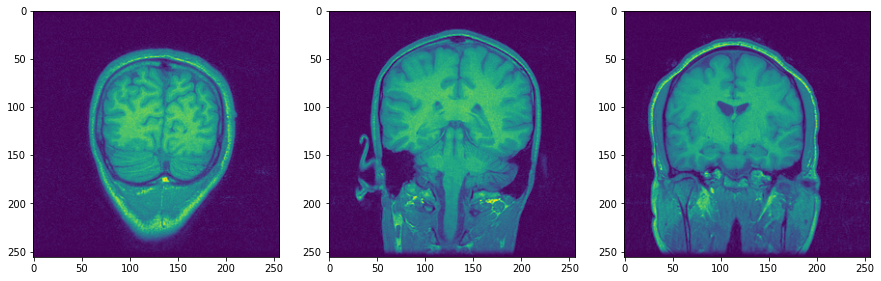

In [ ]:
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,10))
ax0.imshow(data[20])
ax1.imshow(data[49])
ax2.imshow(data[789])

In [ ]:
from torchvision.transforms import InterpolationMode

tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(45, (0.2,0.2), (0.6,0.9), 5, InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.1408],[0.1716])
])


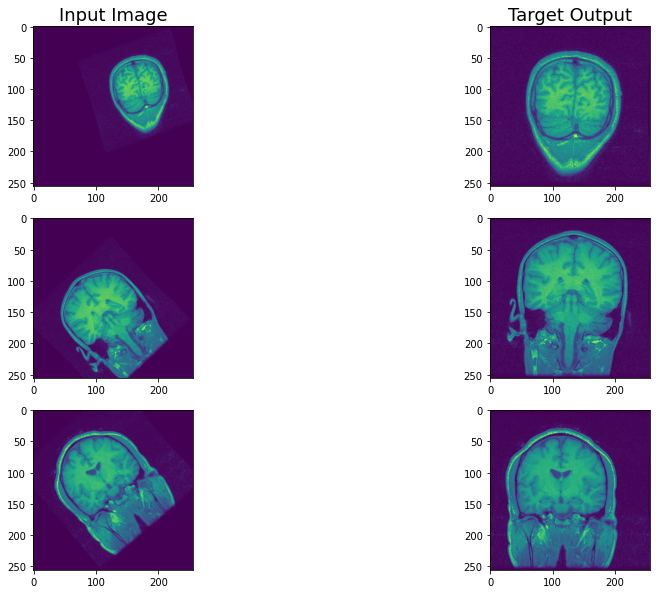

In [ ]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space",tfms)
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,10))
ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(data[20][0].numpy().squeeze())
ax1[0].imshow(data[49][0].numpy().squeeze())
ax2[0].imshow(data[789][0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(data[20][1].numpy().squeeze())
ax1[1].imshow(data[49][1].numpy().squeeze())
ax2[1].imshow(data[789][1].numpy().squeeze())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bs = 32
dl = DataLoader(data, batch_size=bs,
                        shuffle=True, num_workers=2)

In [ ]:
a=next(iter(dl))
a[0].shape, a[1].shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 256, 256]))

In [ ]:
a[0].mean(), a[0].std(), a[0].max()

(tensor(-0.2342), tensor(1.0426), tensor(4.9760))

In [ ]:
a[1].mean(), a[1].std(), a[1].max()

(tensor(0.2092), tensor(1.2069), tensor(5.0070))

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initializing the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        
        res_out = self.conv1(x)
        x = x + res_out.squeeze(1)
        
        return x

model = Net(image_size=256).to(device)

In [ ]:
test_loader = DataLoader(data, batch_size=bs, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters())

loss_fn = nn.L1Loss()


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50*bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl.dataset),
                100. * batch_idx / len(dl), loss.item()))
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
           # print(target)
           # print(output.shape)
            # sum up batch loss
            test_loss += F.nll_loss(output, target.long(), reduction='mean').item()
            # The index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # A batch of training data
        data = next(iter(dl))
        moving, target = data[0].to(device), data[1].cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor = model(moving).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target[:,None]))
        
        # Plot of the results side-by-side
        f, axarr = plt.subplots(3, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Output Images')
        
        axarr[2].imshow(target_grid)
        axarr[2].set_title('Target Images')

In [ ]:
for epoch in range(1, 20):
    train(epoch)
    test()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 256, 256])) that is different to the input size (torch.Size([32, 32, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train Epoch: 1 [0/4800 (0%)]	Loss: 0.827903
Train Epoch: 1 [1600/4800 (33%)]	Loss: 0.858825
Train Epoch: 1 [3200/4800 (67%)]	Loss: 0.862426

Test set: Average loss: 0.0072, Accuracy: 0/4800 (0%)

Train Epoch: 2 [0/4800 (0%)]	Loss: 0.847515
Train Epoch: 2 [1600/4800 (33%)]	Loss: 0.895180
Train Epoch: 2 [3200/4800 (67%)]	Loss: 0.857704

Test set: Average loss: 0.0071, Accuracy: 0/4800 (0%)

Train Epoch: 3 [0/4800 (0%)]	Loss: 0.836021
Train Epoch: 3 [1600/4800 (33%)]	Loss: 0.860207
Train Epoch: 3 [3200/4800 (67%)]	Loss: 0.785630

Test set: Average loss: 0.0072, Accuracy: 0/4800 (0%)

Train Epoch: 4 [0/4800 (0%)]	Loss: 0.848071
Train Epoch: 4 [1600/4800 (33%)]	Loss: 0.810041
Train Epoch: 4 [3200/4920 (65%)]	Loss: 0.808104
Train Epoch: 4 [4800/4920 (97%)]	Loss: 0.857391


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([24, 256, 256])) that is different to the input size (torch.Size([24, 24, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


FileNotFoundError: ignored

In [ ]:
visualize_stn()

In [ ]:
class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        # MRI
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        # Brain Mask
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [ ]:
import torchvision.transforms.functional as TF
import random

In [ ]:
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-25,25)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.25 + 0.7
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [ ]:
data = MRIMaskDataset("/content/drive/MyDrive/LPBA40/native_space", mask_transforms)

In [ ]:
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze())
ax1[0].imshow(im2[0].numpy().squeeze())
ax2[0].imshow(im3[0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze())
ax1[1].imshow(im2[1].numpy().squeeze())
ax2[1].imshow(im3[1].numpy().squeeze())

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4)
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4)
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4)

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4)
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4)
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4)

In [ ]:
bs = 128
data = MRIMaskDataset("/content/drive/MyDrive/LPBA40/native_space", mask_transforms)
dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=4)

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x, mask):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        mask = F.grid_sample(mask, grid)
        
#         res_out = self.conv1(x)
#         x = x + res_out
        
        return x, mask

model = Net(256).to(device)

In [ ]:
#from registration.metrics import mutual_information, jaccard_coeff
from sklearn.metrics import jaccard_score

def accuracy(input, target):
    return 1-torch.sum(abs(input.view(-1)-target.view(-1)))/torch.sum(target)

def binarise(mask):
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return mask

def jaccard_coeff(x, target):
    target = binarise(target.numpy().ravel())
    x = binarise(x.numpy().ravel())
    return jaccard_score(target, x)

def mutual_information(slice1, slice2, n_bins=20):
    """ Mutual information for joint histogram
    Taken from [Mutual Information as an Image Metric]
    (https://matthew-brett.github.io/teaching/mutual_information.html)
    """
    hgram, _, _ = np.histogram2d(
                        slice1.numpy().ravel(),
                        slice2.numpy().ravel(),
                        bins=n_bins)
    # Convertions of bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=5e-2)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()
# lr_decay = lambda epoch: 0.9 ** epoch
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_decay])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,5)

def train(epoch):
    losses = []
    model.train()
    for batch_idx, (data, target, input_mask, target_mask) in enumerate(dl):
        data, target = data.to(device), target.to(device)
        input_mask, target_mask =  input_mask.to(device), target_mask.to(device)

        optimizer.zero_grad()
        output_image, output_mask = model(data, input_mask)

        loss = loss_fn(output_image, target)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx  == 0:
            print(f'Train Epoch {epoch}:\t Loss: {round(loss.item(),4)}\t Mask accuracy: {round(accuracy(output_mask,target_mask).item()*100,2)}%\t Jaccard: {round(jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu()),4)}\t MI: {round(mutual_information(output_image.detach().cpu(), target.detach().cpu()), 4)}')
        if batch_idx%2400 == 0:
            losses.append(loss.item())
            
    return losses

In [ ]:
losses = []
for epoch in range(1, 40):
    losses += train(epoch)

In [ ]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        dl = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)        
        # Get a batch of training data
        moving, target, input_mask, target_mask = next(iter(dl))
        moving, target = moving.to(device), target.cpu()
        input_mask, target_mask =  input_mask.to(device), target_mask.cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor, transformed_mask = model(moving, input_mask)
        transformed_input_tensor, transformed_mask = transformed_input_tensor.cpu(), transformed_mask.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        in_mask = torchvision.utils.make_grid(input_mask.cpu())

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        out_mask = torchvision.utils.make_grid(transformed_mask)
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target))
        target_mask = torchvision.utils.make_grid(target_mask[:, None])
        
        # Plot of the results side-by-side
        f, axarr = plt.subplots(4, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].imshow(in_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].imshow(target_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[1].set_title('Output Images with Target Masks')
        
        axarr[2].imshow(target_grid)
        axarr[2].imshow(out_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[2].set_title('Target Images with Output masks')
        
        axarr[3].imshow(target_mask.sum(0), cmap="Reds")
        axarr[3].imshow(out_mask.sum(0), alpha=0.5, cmap="Blues")
        axarr[3].set_title('Target (Red) vs Output Masks (Blue)')

In [ ]:
visualize_stn()